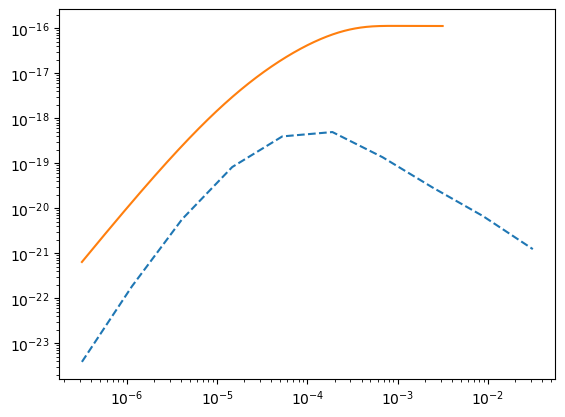

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import scipy
import math

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789

# _r =  2.6392235755368e-06
# _K = 8.061743253740993e-05
# _gain = np.sqrt(335982165125421.5 )

_r =  1.673973370516074e-06
_K = 7.264521400417836e-05
_gain = np.sqrt(630330834489321.9)

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous


def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))


times_analytic = np.logspace(-6.5, -1.5, 1000)


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 2000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []

for i in range(num_samples):
    results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], 0* np.sqrt(_k_b*_temp/_m))
speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))

# High precision for inverse Laplace
mp.dps = 30

# History term in Laplace domain - see overlead doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 2/sqrt(-tau) - 2 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1
N = 100
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
z = 3*_r**2*np.sqrt(np.pi*_viscous*_rho_f)

# Fixed t value at which to evaluate MSD_history(t) importance
t_evals = np.logspace(-6.5, -1.5, 10)
msd_hs = []

for t_eval in t_evals:
    print("x")
    # Compute f(t, tau) for all tau
    f_vals = np.array([f(t_eval, tau) for tau in tau_array]) # tau is backwards time, t_eval is forwards

    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = f_vals[:, np.newaxis]
    f2 = f_vals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aprroximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...

    # Integrate over tau1 and tau2
    msd_history = trapz(trapz(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)

plt.plot(t_evals, msd_hs, linestyle='dashed', label="g")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = "msd")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.show()